In [ ]:
#Group Information:

#Name                   | Roll Number
#---------------------------------------
#Aditya Aman            | NS25Z035
#Pravitt Sethi          | NS25Z022
#Srivatsan Sarvesan     | DA24E001

Importing required libraries

In [24]:
import subprocess
import os
import re
import json
from prettytable import PrettyTable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import radians, cos, sin, asin, sqrt

Haversine distance as seen on stackoverflow

In [4]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


Router class: 
- An object of this class stores all information about the router
- Relevant functions for working with RTTs

In [5]:
class router:
    
    def __init__(self, ip, city, region, country, location, org):
        self.ip = ip
        self.city = city
        self.region = region
        self.country = country
        self.latitude, self.longitude = location.split(",")
        self.org = org
        self.timestamps = []

    def __str__(self):
        return f"IP: {self.ip}\nCity: {self.city}\nRegion: {self.region}\nCountry: {self.country}\nLocation: {self.latitude}, {self.longitude}\nOrg: {self.org}\n"
        
    def add_timestamp(self, t):
        self.timestamps.append(t)

def get_average_time(r):
    if len(r.timestamps) == 0:
        return 0
    return sum(r.timestamps) / len(r.timestamps)

def get_std_dev_time(r):
    if len(r.timestamps) == 0:
        return 0
    return np.std(r.timestamps)

Maintaining a record of routers
- A dictionary that contains router IPs as keys and router class object as corresponding values
- A set that contains the seen router IPs and allows us to do O(1) membership check to minimize # API calls

In [6]:
routers = set()
router_dict = {}

This function takes output of traceroute -n (run 10 times) as input
- Counts and returns valid, invalid, and total hops  
- Creates router class objects and stores them in the dictionary  
- Adds RTTs to the relevant router object  

In [7]:
def get_ip_info(lines):
    total_hops = 0
    invalid_hops = 0
    valid_hops = 0
    for line in lines:  # Skip the first line

        if "traceroute" in line:
            continue

        total_hops += 1
        if "*" in line:
            invalid_hops += 1
        else:
            valid_hops += 1

        line = line.strip()
        line = line.replace("  ", " ")
        line = line.replace(" ms", "ms")
        li = line.split(" ")

        # First element is the hop number
        # Each IP address is followed by timestamp for it in ms
        for i in range(1, len(li)):
            if "ms" in li[i]:
                if "*" not in li[i]:
                    router_dict[ip].add_timestamp(float(li[i][:-2]))
            elif li[i] == "*":
                continue
            else:
                ip = li[i]
                if ip not in routers:
                    routers.add(ip)
                    if ip.startswith("192.168.") or ip.startswith("10.") or ip.startswith(tuple(f"172.{i}." for i in range(16, 32))):
                        router_dict[ip] = router(ip, "Chennai", "Madras", "IN", "12.9915,80.2336", "IIT Madras")
                    else:
                        command = f"curl -u 510873564682e6:24shalini -s --max-time 6 https://ipinfo.io/{ip}"
                        output = subprocess.run(command, shell=True, capture_output=True, text=True)
                        info = json.loads(output.stdout)
                        router_dict[ip] = router(info["ip"], info["city"], info["region"], info["country"], info["loc"], info["org"])

    return (valid_hops, invalid_hops, total_hops)


                    

This function also takes output of traceroute -n (run 10 times) as input; Also a hop number 'n'
- Returns a string containing path returned by traceroute
- Skips invalid hops (ones containing a '*')
- Returns only the specified path number

In [8]:
def get_path(lines, n):
    if n <= 0 or n >= 11:
        raise ValueError("n should be greater than 0 and less than 11")
    
    s = ""
    counter = 0
    for line in lines:
        if "traceroute" in line:
            counter += 1
            continue
        if counter < n:
            continue
        if counter == n + 1:
            break
        if "*" in line:
            continue
        line = line.strip()
        line = line.replace("  ", " ")
        line = line.replace(" ms", "ms")
        s += line + "\n"

    return s

This function also takes output of traceroute -n (run 10 times) as input
- Returns a list of tuples containing distance between two routers and difference between their RTTs (averages or hop-wise)
- Also returns a set of router IPs that show per packet load balancing and count of such hops
- Skips the invalid hops
- This functions treats hops with per packet load balancing as a regular hop and takes average of the first IP in the line

In [9]:
def get_plot_info(lines):
    d_t = []
    plb_ip = set()
    plb_count = 0
    prev_rtr = None
    for line in lines:
        if "*" in line:
            continue
        line = line.strip()
        line = line.replace("  ", " ")
        line = line.replace(" ms", "ms")
        if "traceroute" in line:
            prev_rtr = None
            continue
        
        all_ips = re.findall(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', line)
        if len(all_ips) == 3:
            plb_count += 1
            all_ips_set = set(all_ips)
            plb_ip.update(all_ips_set)
        if prev_rtr is None:
            ip = re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', line)
            rtr = router_dict[ip.group()]
            prev_rtr = rtr
            timestamps = re.findall(r'\b\d+\.\d{3}ms\b', line)
            timestamps = [float(t[:-2]) for t in timestamps]
            prev_time = sum(timestamps) / len(timestamps)
        else:
            timestamps = re.findall(r'\b\d+\.\d{3}ms\b', line)
            timestamps = [float(t[:-2]) for t in timestamps]
            curr_time = sum(timestamps) / len(timestamps)
            ip = re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', line)
            curr_rtr = router_dict[ip.group()]
            distance = haversine(float(prev_rtr.longitude), float(prev_rtr.latitude), float(curr_rtr.longitude), float(curr_rtr.latitude))
            # This is the time difference between the two routers calculated by taking the average of the RTTs of only two hops
            d_t.append((distance, curr_time - prev_time))
            # This is the time difference between the averages of RTTs of the two routers
            # d_t.append((distance, get_average_time(curr_rtr) - get_average_time(prev_rtr)))
            prev_time = curr_time
            prev_rtr = curr_rtr

    return (d_t, plb_ip, plb_count)

This function takes a dictionary having country names as keys and paths containing valid hops as values
- It creates and returns a dictionary with keys as country names and a list of hop-tuples as required for plotting
- It calculates and returns the minimum and maximum latency between two hops

In [10]:
def get_hops_list(retrieved_path):
    hops_dict = {}

    for c in retrieved_path:
        hops_dict[c] = []
        lines = retrieved_path[c].split("\n")
        for line in lines:
            if not line.strip():
                continue
            ip = re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', line)

            rtr = router_dict[ip.group()]
            hops_dict[c].append((rtr.ip, rtr.city, rtr.country, float(rtr.latitude), float(rtr.longitude)))

    min_latency = float('inf')
    max_latency = float('-inf')

    for l in hops_dict.values():
        prev = None
        for h in l:
            if prev:
                t = abs(get_average_time(router_dict[h[0]]) - get_average_time(router_dict[prev[0]]))
                if t > 0 and haversine(h[4], h[3], prev[4], prev[3]) > 50:
                    min_latency = min(min_latency, t)
                max_latency = max(max_latency, t)
                prev = h
            else:
                prev = h

    return (hops_dict, min_latency, max_latency)



# (a) Total Number of Valid Measurement Entries Across All Traces

This piece of code goes through all files inside 'new_outputs' folder
- Fetches all lines from the files
- Runs the previously defined functions on the sets of lines from each file
- Creates a hops_dict dictionary required for plotting the traceroute paths on the map
- Creates and displays a table showing valid, invalid and total hops for each country's traceroute

In [20]:
# Iterate through all files in the folder
folder_path = "new_outputs"
hops_info = {}
retrieved_path = {}
distance_time = []
load_balancing_routers = set()
load_balancing_instances = 0
path_number = 3 # Path number to be retrieved
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)


    with open(file_path, 'r') as file:
        lines = file.readlines()
        hops_info[filename[:-4]] = get_ip_info(lines)
        retrieved_path[filename[:-4]] = get_path(lines, path_number)
        (d_t, plb_ip,plb_count) = get_plot_info(lines)
        distance_time += d_t
        load_balancing_routers.update(plb_ip)
        load_balancing_instances += plb_count

        
(hops_dict, min_latency, max_latency) = get_hops_list(retrieved_path)
print(f"Min latency: {min_latency}")
print(f"Max latency: {max_latency}")

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Country", "Valid Hops", "Invalid Hops", "Total Hops"]

# Totals for all hops
total_valid = 0
total_invalid = 0
total_all = 0

# Add rows to the table
for key, value in hops_info.items():
    valid, invalid, total = value
    total_valid += valid
    total_invalid += invalid
    total_all += total
    table.add_row([key, valid, invalid, total])

# Add a visual separator row
separator_row = ['-' * len(field) for field in table.field_names]
table.add_row(separator_row)

# Add grand total row
table.add_row(["TOTAL", total_valid, total_invalid, total_all])



# Print the table
print(table)

Min latency: 0.030083333333266182
Max latency: 378.13010366826154
+--------------+------------+--------------+------------+
|   Country    | Valid Hops | Invalid Hops | Total Hops |
+--------------+------------+--------------+------------+
|     Mali     |     93     |     207      |    300     |
| Burkina Faso |    143     |     157      |    300     |
|    Zambia    |    139     |     161      |    300     |
|  Madagascar  |    278     |      22      |    300     |
|    Libya     |    130     |     170      |    300     |
|    Angola    |     98     |      51      |    149     |
|    Rwanda    |    153     |      27      |    180     |
|    Uganda    |    129     |     171      |    300     |
|   Morocco    |     99     |     201      |    300     |
|   Namibia    |    160     |     140      |    300     |
|   DR Congo   |     70     |     230      |    300     |
|   Botswana   |    113     |     187      |    300     |
|   Cameroon   |    157     |      93      |    250     |
|   Se

#  (b) Unique Router IPs and RTT Statistics

Number of unique router IPs seen (except the ones with invalid hops)

In [17]:
# Number of unique routers
print(f"Number of unique routers: {len(router_dict.keys())}")

Number of unique routers: 200


Highest Standard Deviation:
- This piece of code sorts the routers based the standard deviation of their RTTs
- Displays the top n (5 right now) routers and their information with highest standard deviation

In [18]:
# Create a PrettyTable object for routers
router_table = PrettyTable()
router_table.field_names = ["S. no.", "Router IP", "Average Time (ms)", "Std Dev Time (ms)", "City", "Region", "Country"]
n = 5 # Number of routers to display
# Sort the router_dict by standard deviation in descending order
sorted_routers = sorted(router_dict.items(), key=lambda x: get_std_dev_time(x[1]), reverse=True)
i = 1
for ip, router_obj in sorted_routers[:n]:
    avg_time = round(get_average_time(router_obj), 3)
    std_dev_time = round(get_std_dev_time(router_obj), 3)
    city = router_obj.city
    region = router_obj.region
    country = router_obj.country
    router_table.add_row([i, ip, avg_time, std_dev_time, city, region, country])
    i += 1


print(f"Router Table (top {n} - sorted by std dev):")
# Print the router table
print(router_table)

Router Table (top 5 - sorted by std dev):
+--------+----------------+-------------------+-------------------+--------------+--------------+---------+
| S. no. |   Router IP    | Average Time (ms) | Std Dev Time (ms) |     City     |    Region    | Country |
+--------+----------------+-------------------+-------------------+--------------+--------------+---------+
|   1    | 81.52.166.146  |      309.835      |      117.057      |    Madrid    |    Madrid    |    ES   |
|   2    | 105.255.2.126  |      384.612      |       93.037      |  Cape Town   | Western Cape |    ZA   |
|   3    | 197.215.159.82 |      346.018      |       81.024      |   Tripoli    |   Tripoli    |    LY   |
|   4    |  41.84.12.155  |      337.732      |       70.997      | Bloemfontein |  Free State  |    ZA   |
|   5    | 105.255.2.130  |      333.411      |       70.316      |  Cape Town   | Western Cape |    ZA   |
+--------+----------------+-------------------+-------------------+--------------+------------

# (c) Global Visualization of Router Locations and Latency-Based Connectivity

Colour-coding links
- This function takes latency of the edge, minimum latency and maximum latency as inputs
- It returns a colour code based on the latency (Lower towards green and Higher towards red)

In [26]:
def value_to_color(t, min_latency, max_latency):
    """
    Maps a float between 0 and 1 to a hex color code.
    0 => Green (#00ff00), 1 => Red (#ff0000)
    """
    val = (t-min_latency) / (max_latency-min_latency)
    if val < 0:
        val = 0
    elif val > 1:
        val = 1

    r = int(255 * val)
    g = int(255 * (1 - val))
    b = 0

    return f'#{r:02x}{g:02x}{b:02x}'

Plotting Function:
- This function takes a list of valid hops for a country and the country name as input
- It plots the routers and their links for the path
- It skips the links and routers that are less than 50km from the previous router
- It uses value_to_color function to colour code the links based on their latency
- Prints information of each hop (origin and destination) while plotting

In [30]:
def plot_hops(hops, c):

    # Setup the map figure and axes with a Mercator projection
    fig = plt.figure(figsize=(10, 10))  # Create a figure with specified size
    ax = plt.axes(projection=ccrs.Mercator())  # Create a map axis with Mercator projection
    ax.set_extent([-25, 110, -40, 60], crs=ccrs.PlateCarree())  # Set the map extent (longitude and latitude bounds)
    ax.set_extent([-130, 110, -40, 60], crs=ccrs.PlateCarree())

    # Add map features like land, ocean, borders, and coastlines
    ax.add_feature(cfeature.LAND, facecolor='white')  # Add land with white color
    ax.add_feature(cfeature.OCEAN, facecolor='#d2dff7')  # Add ocean with light blue color
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)  # Add country borders with thin lines
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Add coastlines with thin lines
    ax.gridlines(draw_labels=True)  # Add gridlines with labels for latitude and longitude

    # Initialize a variable to store the previous coordinates for connecting lines
    prev_coords = None

    # Loop through each hop in the list to plot routers and paths
    for ip, city, country, lat, lon in hops:
        if prev_coords:
            # check if the location of current router is within 50 km of the previous router
            dist = haversine(prev_coords[0], prev_coords[1], lon, lat)
            if dist < 50:
                continue  # Skip plotting if the distance is less than 50 km
            else:
                ax.plot(lon, lat, 'bo', markersize=6, transform=ccrs.PlateCarree())
                prev_lon, prev_lat = prev_coords
                color = value_to_color(abs(get_average_time(router_dict[ip]) - get_average_time(router_dict[prev_ip])), min_latency, max_latency)
                print(f"Drawing line from {prev_ip} ({router_dict[prev_ip].city}) to {ip} ({router_dict[ip].city}) for time {round(abs(get_average_time(router_dict[ip]) - get_average_time(router_dict[prev_ip])),3)}")
                ax.plot([prev_lon, lon], [prev_lat, lat], color=color, linewidth=2, transform=ccrs.PlateCarree())
                prev_coords = (lon, lat)
                prev_ip = ip
        else:
            # Plot the first router as a red dot on the map
            ax.plot(lon, lat, 'bo', markersize=6, transform=ccrs.PlateCarree())
            prev_coords = (lon, lat)
            prev_ip = ip



        # Update the previous coordinates to the current router's coordinates

    # Add a title to the map
    plt.title(f"Traceroute Path Visualization for {c}")
    
    # Add colorbar
    custom_cmap = LinearSegmentedColormap.from_list("CustomLatency", ["#00ff00", "#ff0000"])
    norm = mcolors.Normalize(vmin=min_latency, vmax=max_latency)
    sm = ScalarMappable(norm=norm, cmap=custom_cmap)
    sm.set_array([])  
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.6, pad=0.02)
    cbar.set_label("Latency (ms)")

    # Adjust layout to prevent overlapping elements
    plt.tight_layout()

    # Display the map
    plt.show()
        

Plotting all the paths on map

Plotting hops for Mali
Drawing line from 10.44.51.254 (Chennai) to 182.79.134.142 (Marseille) for time 144.289
Drawing line from 182.79.134.142 (Marseille) to 157.238.230.19 (Paris) for time 30.53
Drawing line from 157.238.230.19 (Paris) to 196.200.63.177 (Bamako) for time 66.338


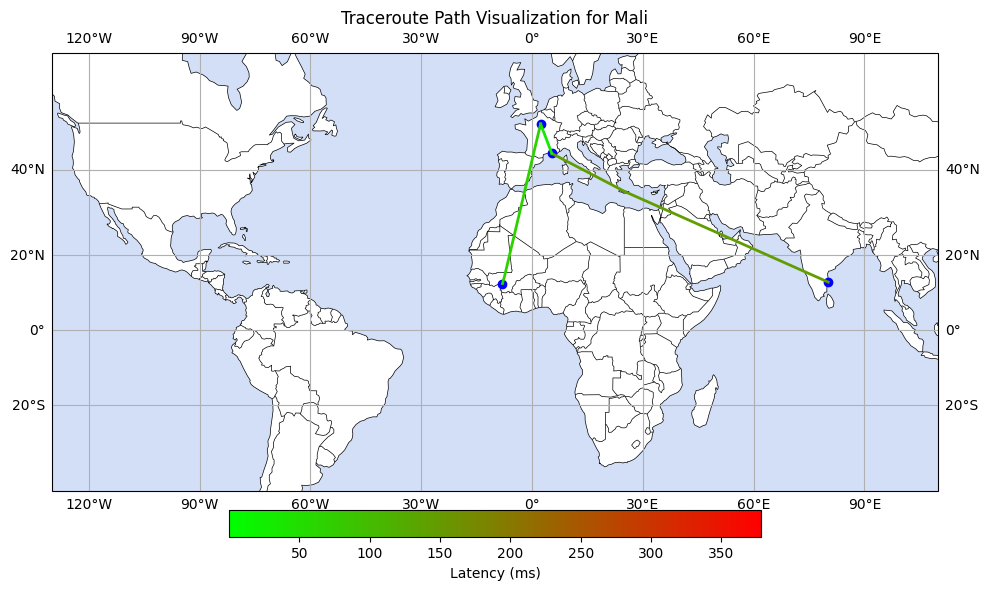

Plotting hops for Burkina Faso
Drawing line from 10.44.51.254 (Chennai) to 184.104.226.34 (Lisbon) for time 154.713
Drawing line from 184.104.226.34 (Lisbon) to 102.67.97.120 (Lagos) for time 61.911
Drawing line from 102.67.97.120 (Lagos) to 102.67.96.15 (Ouagadougou) for time 25.913
Drawing line from 102.67.96.15 (Ouagadougou) to 102.67.96.30 (Accra) for time 2.104
Drawing line from 102.67.96.30 (Accra) to 102.67.97.151 (Ouagadougou) for time 7.422


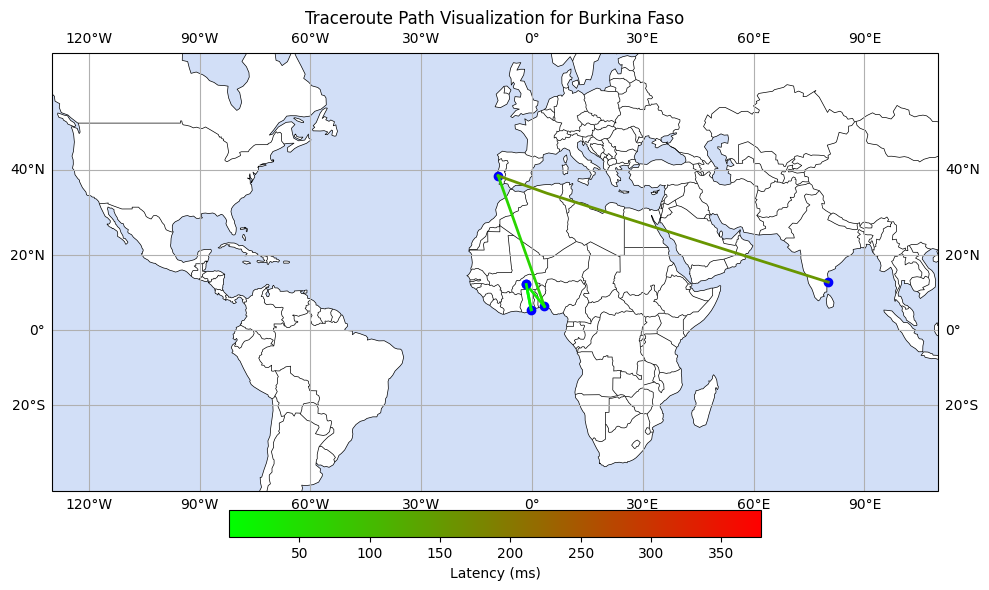

Plotting hops for Zambia
Drawing line from 10.44.51.254 (Chennai) to 184.104.188.210 (Cape Town) for time 284.148
Drawing line from 184.104.188.210 (Cape Town) to 184.105.223.209 (Johannesburg) for time 40.254
Drawing line from 184.105.223.209 (Johannesburg) to 102.220.219.69 (Pretoria) for time 25.55
Drawing line from 102.220.219.69 (Pretoria) to 102.220.216.169 (Johannesburg) for time 11.74
Drawing line from 102.220.216.169 (Johannesburg) to 196.46.212.2 (Kitwe) for time 8.68
Drawing line from 196.46.212.2 (Kitwe) to 196.46.196.241 (Kafue) for time 0.188


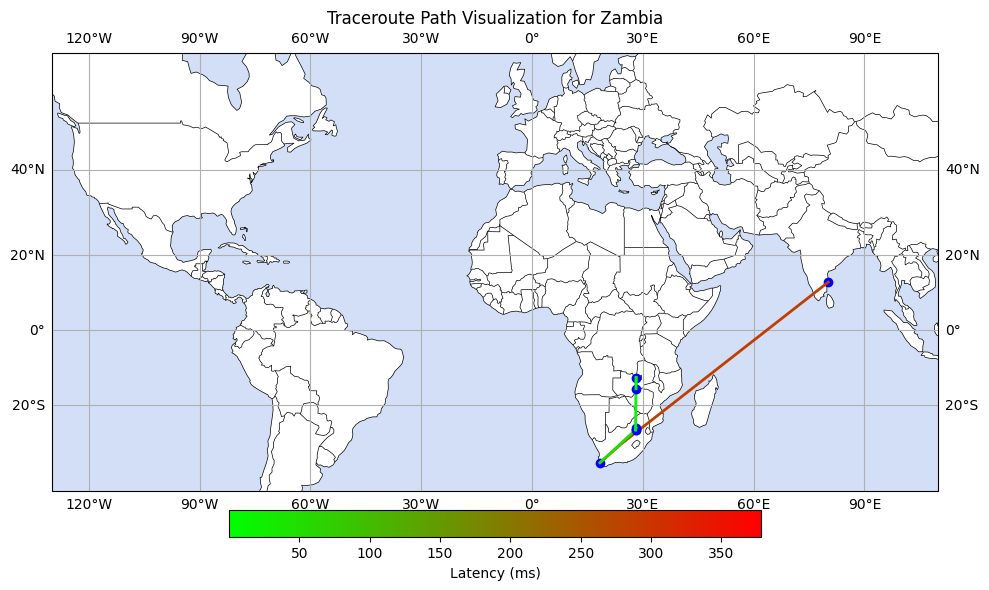

Plotting hops for Madagascar
Drawing line from 10.44.51.254 (Chennai) to 102.16.86.5 (London) for time 152.899
Drawing line from 102.16.86.5 (London) to 41.188.60.214 (Paris) for time 5.946
Drawing line from 41.188.60.214 (Paris) to 102.16.86.83 (Antananarivo) for time 193.019
Drawing line from 102.16.86.83 (Antananarivo) to 154.126.82.217 (Paris) for time 6.856
Drawing line from 154.126.82.217 (Paris) to 102.16.86.28 (Antananarivo) for time 9.727


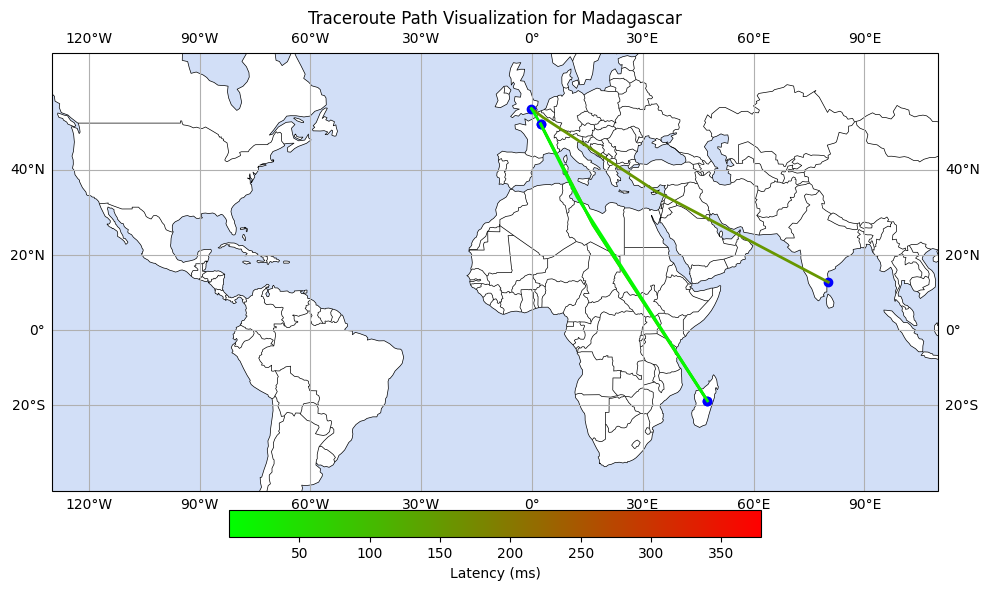

Plotting hops for Libya
Drawing line from 10.44.51.254 (Chennai) to 62.115.162.62 (Los Angeles) for time 229.04
Drawing line from 62.115.162.62 (Los Angeles) to 62.115.136.119 (Dallas) for time 89.885
Drawing line from 62.115.136.119 (Dallas) to 195.22.197.205 (Palermo) for time 18.03
Drawing line from 195.22.197.205 (Palermo) to 197.215.159.82 (Tripoli) for time 39.945


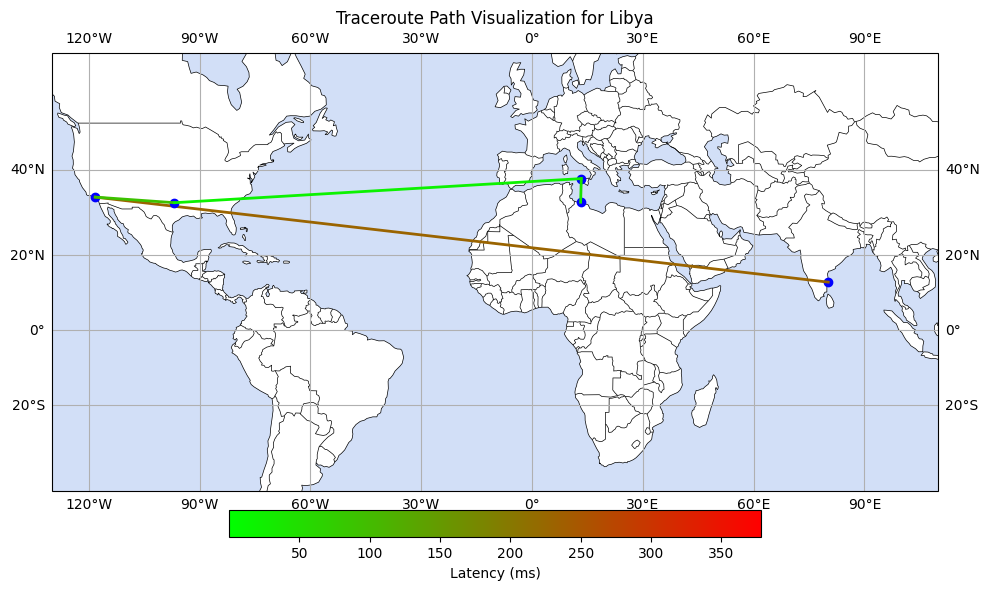

Plotting hops for Angola
Drawing line from 10.44.51.254 (Chennai) to 197.234.113.76 (Luanda) for time 275.336


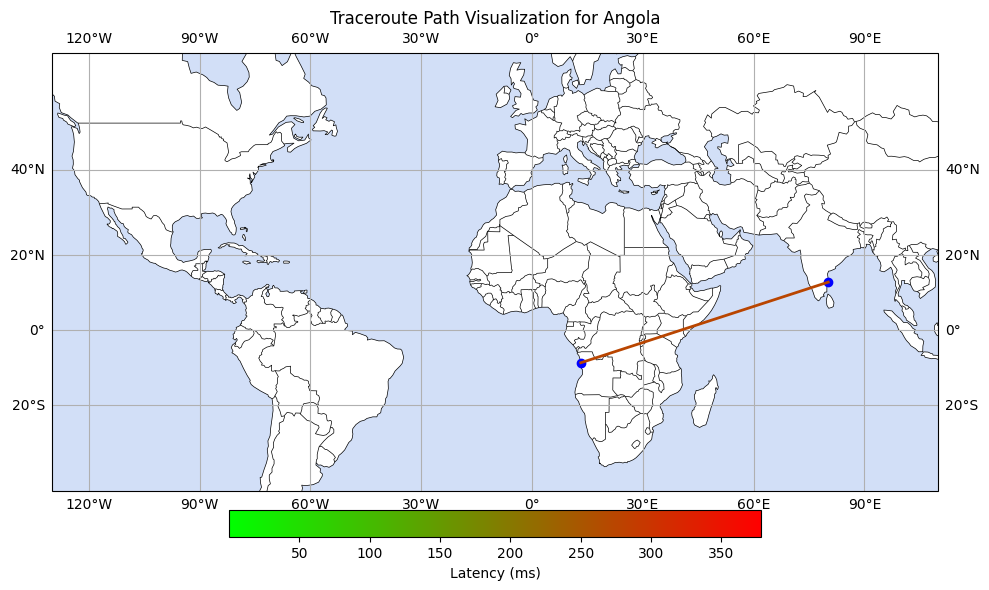

Plotting hops for Rwanda
Drawing line from 10.44.51.254 (Chennai) to 182.79.134.142 (Marseille) for time 144.289
Drawing line from 182.79.134.142 (Marseille) to 5.11.12.33 (Mombasa) for time 166.424
Drawing line from 5.11.12.33 (Mombasa) to 197.155.90.252 (Nairobi) for time 3.566
Drawing line from 197.155.90.252 (Nairobi) to 197.155.94.221 (Kampala) for time 14.918
Drawing line from 197.155.94.221 (Kampala) to 41.216.104.145 (Kigali) for time 0.03


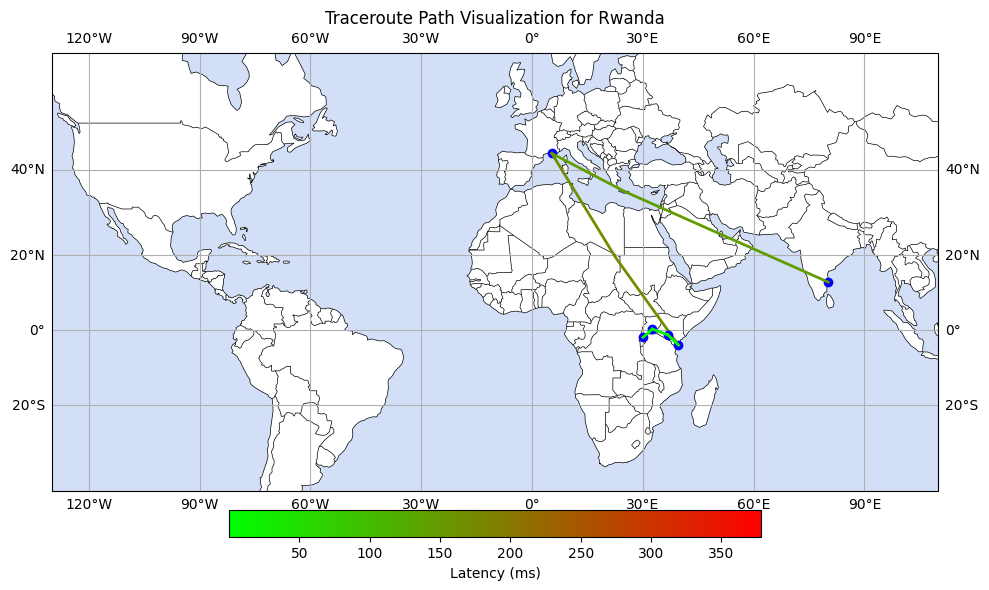

Plotting hops for Uganda
Drawing line from 10.44.51.254 (Chennai) to 182.79.134.142 (Marseille) for time 144.289
Drawing line from 182.79.134.142 (Marseille) to 5.11.12.33 (Mombasa) for time 166.424
Drawing line from 5.11.12.33 (Mombasa) to 197.155.90.252 (Nairobi) for time 3.566
Drawing line from 197.155.90.252 (Nairobi) to 197.155.94.127 (Kampala) for time 7.91


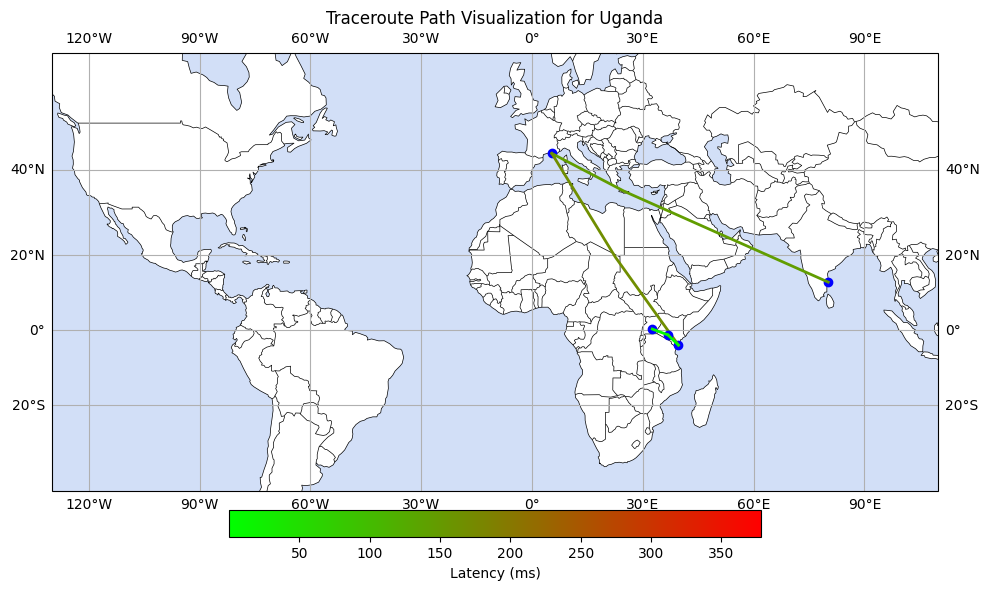

Plotting hops for Morocco
Drawing line from 10.44.51.254 (Chennai) to 62.115.162.62 (Los Angeles) for time 229.04
Drawing line from 62.115.162.62 (Los Angeles) to 81.52.166.146 (Madrid) for time 75.616


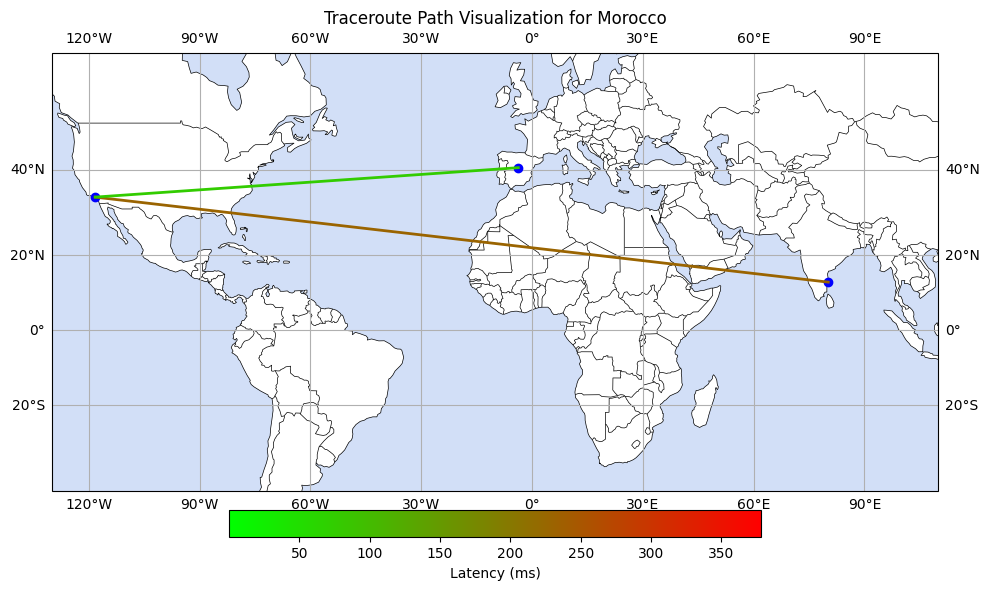

Plotting hops for Namibia
Drawing line from 10.44.51.254 (Chennai) to 182.79.134.142 (Marseille) for time 144.289
Drawing line from 182.79.134.142 (Marseille) to 105.16.9.13 (Amsterdam) for time 155.41
Drawing line from 105.16.9.13 (Amsterdam) to 105.16.13.126 (London) for time 27.23
Drawing line from 105.16.13.126 (London) to 105.25.160.125 (Cape Town) for time 15.943
Drawing line from 105.25.160.125 (Cape Town) to 41.84.12.155 (Bloemfontein) for time 21.566
Drawing line from 41.84.12.155 (Bloemfontein) to 41.84.12.46 (Midrand) for time 2.823


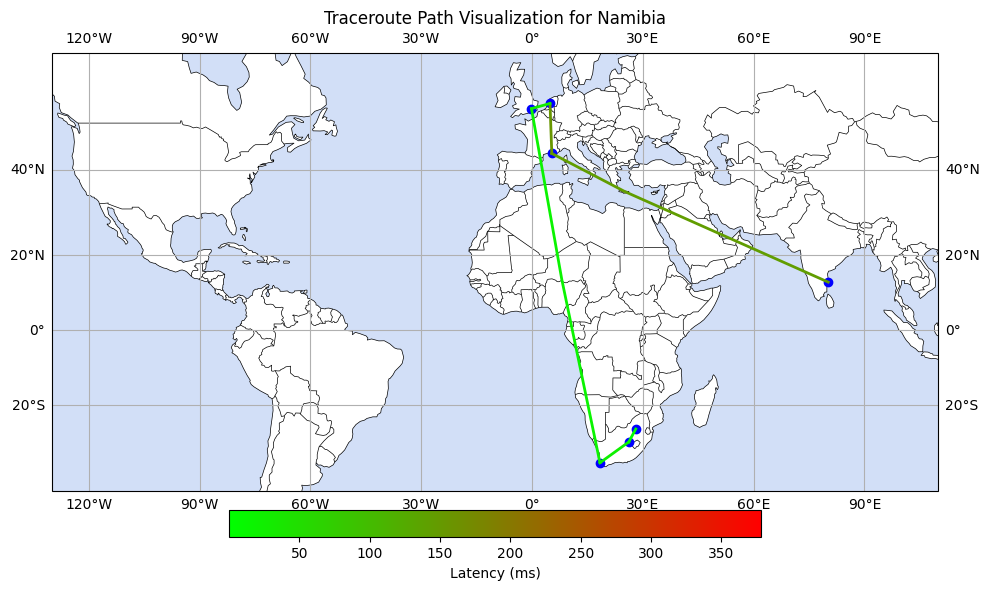

Plotting hops for DR Congo
Drawing line from 10.44.51.254 (Chennai) to 105.255.2.126 (Cape Town) for time 379.433


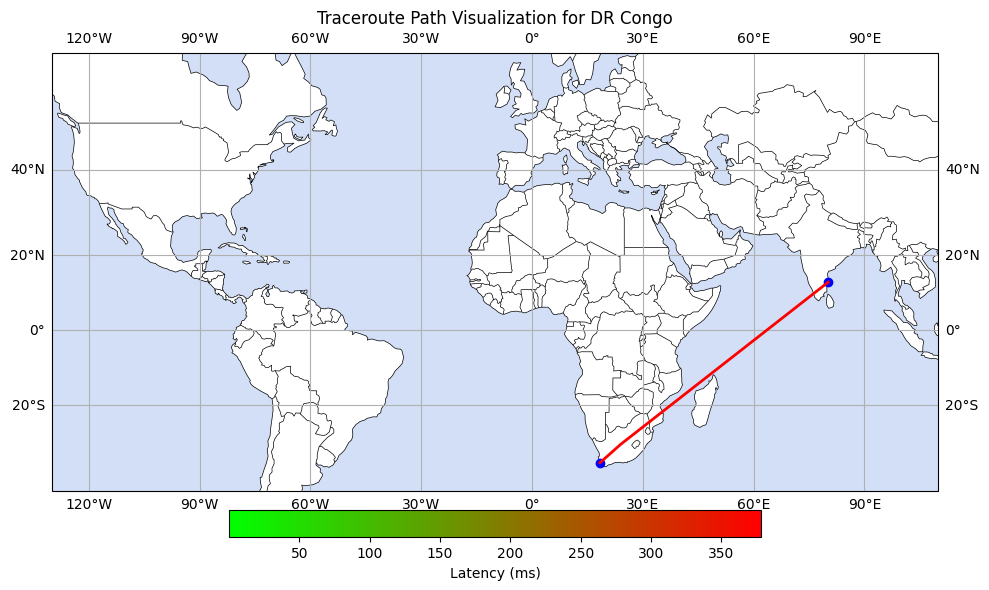

Plotting hops for Botswana
Drawing line from 10.44.51.254 (Chennai) to 182.79.134.142 (Marseille) for time 144.289
Drawing line from 182.79.134.142 (Marseille) to 41.181.244.240 (Amsterdam) for time 23.97
Drawing line from 41.181.244.240 (Amsterdam) to 41.181.190.185 (Johannesburg) for time 7.159
Drawing line from 41.181.190.185 (Johannesburg) to 41.181.105.49 (Milan) for time 4.027
Drawing line from 41.181.105.49 (Milan) to 41.181.251.38 (Johannesburg) for time 200.587


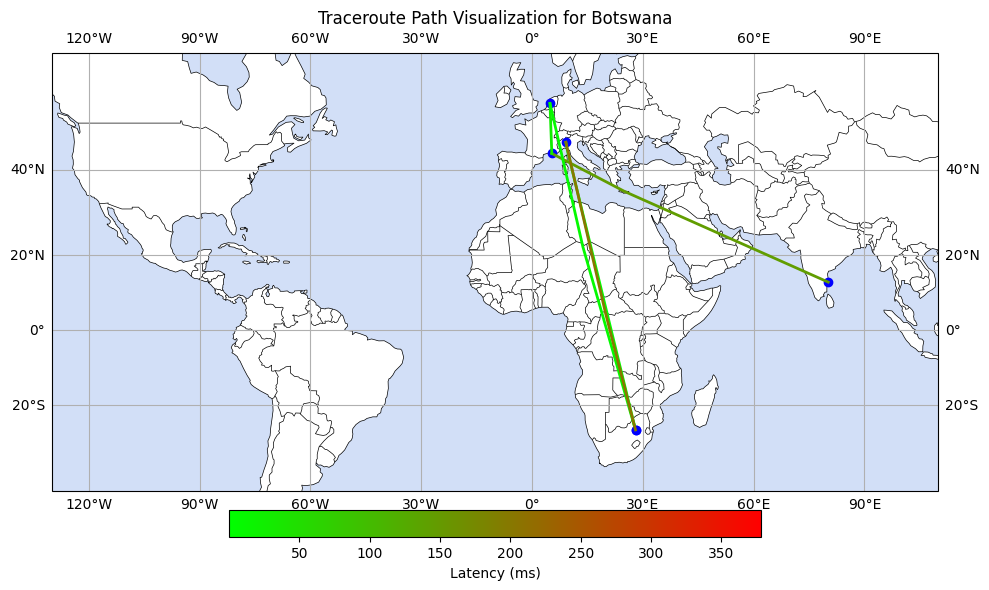

Plotting hops for Cameroon
Drawing line from 10.44.51.254 (Chennai) to 154.54.56.125 (Bilbao) for time 176.579
Drawing line from 154.54.56.125 (Bilbao) to 154.54.63.189 (Lisbon) for time 13.042
Drawing line from 154.54.63.189 (Lisbon) to 149.6.144.98 (Lagos) for time 76.302
Drawing line from 149.6.144.98 (Lagos) to 154.72.188.97 (Douala) for time 79.859


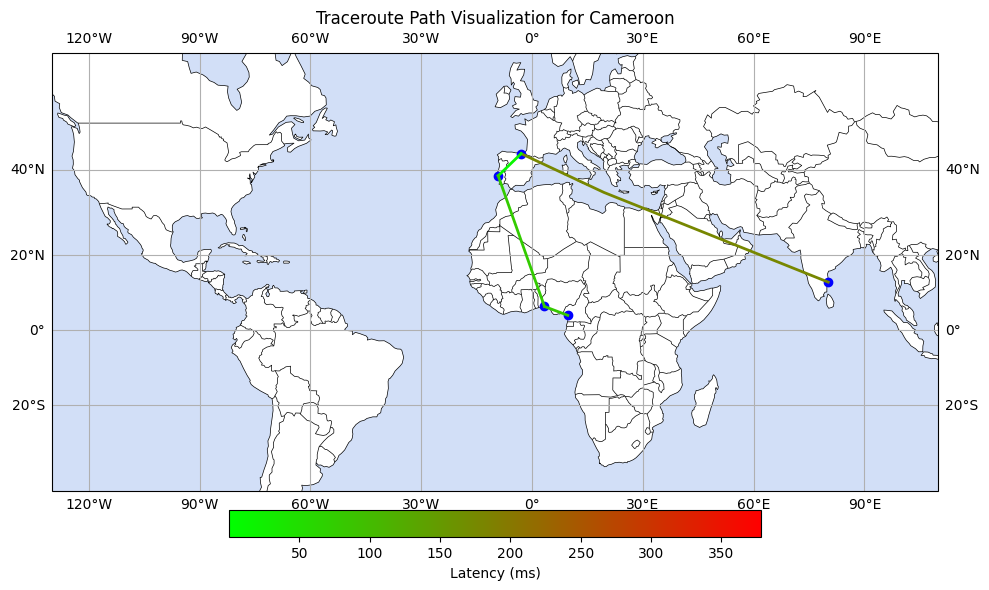

Plotting hops for Senegal
Drawing line from 10.44.51.254 (Chennai) to 62.115.162.62 (Los Angeles) for time 229.04
Drawing line from 62.115.162.62 (Los Angeles) to 193.251.128.187 (Paris) for time 31.874
Drawing line from 193.251.128.187 (Paris) to 196.207.219.176 (Dakar) for time 37.456


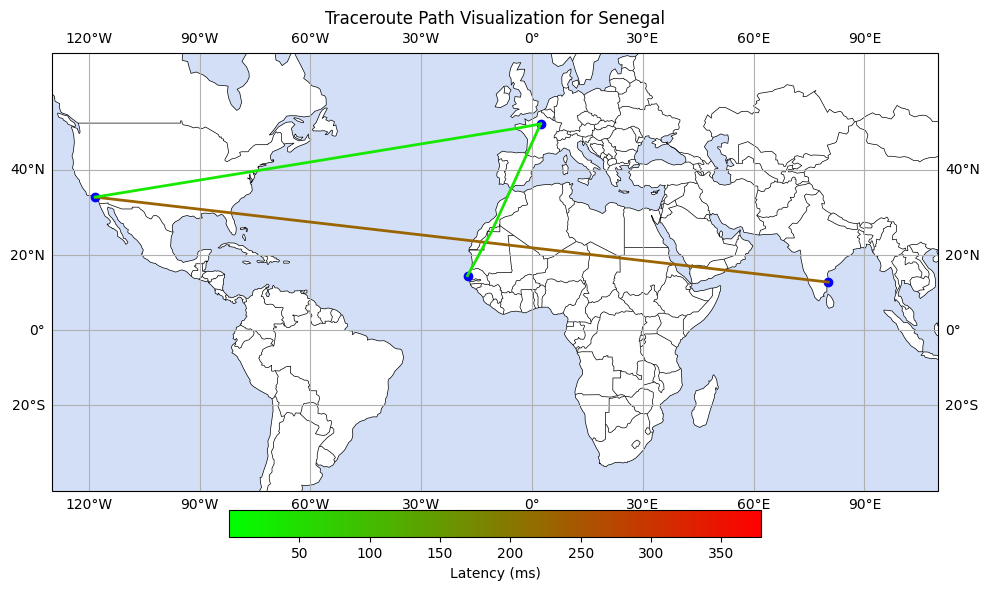

In [31]:
for c in hops_dict:
    print(f"Plotting hops for {c}")
    plot_hops(hops_dict[c], c)

# (d) Correlation Between Physical Distance and Latency

Using the Distance-Time list of tuples to draw the scatter plot

Correlation Coefficient: 0.70


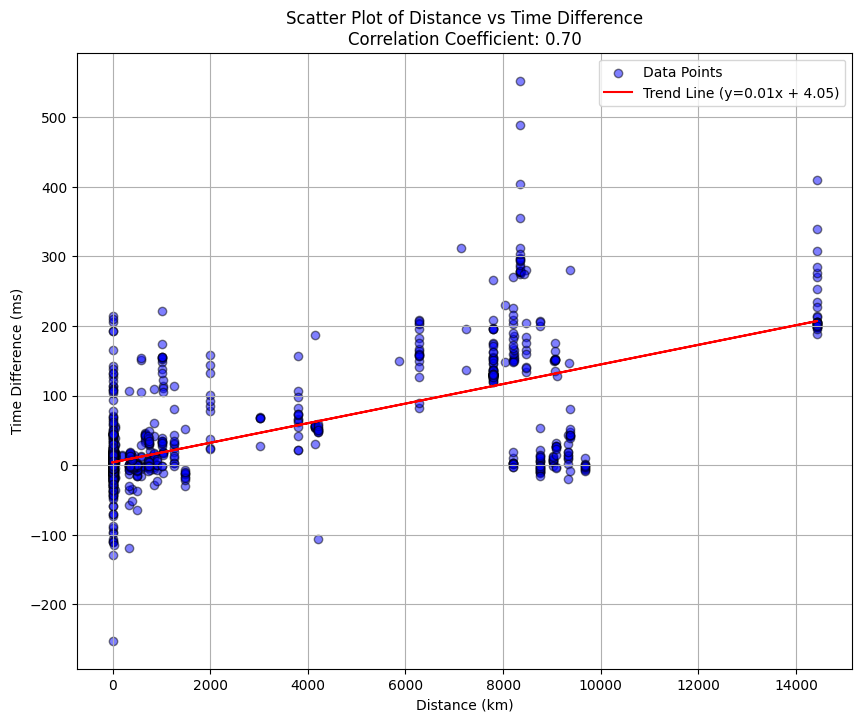

In [32]:
# Extract distances and time differences from distance_time
distances = [dt[0] for dt in distance_time]
time_differences = [dt[1] for dt in distance_time]

# Compute the correlation coefficient
correlation_matrix = np.corrcoef(distances, time_differences)
correlation_coefficient = correlation_matrix[0, 1]

# Fit a trend line
coefficients = np.polyfit(distances, time_differences, 1)
trend_line = np.poly1d(coefficients)

# Plot the scatter plot with the trend line
plt.figure(figsize=(10, 8))
plt.scatter(distances, time_differences, alpha=0.5, c='blue', edgecolors='k', label='Data Points')
plt.plot(distances, trend_line(distances), color='red', label=f'Trend Line (y={coefficients[0]:.2f}x + {coefficients[1]:.2f})')
plt.title(f"Scatter Plot of Distance vs Time Difference\nCorrelation Coefficient: {correlation_coefficient:.2f}")
plt.xlabel("Distance (km)")
plt.ylabel("Time Difference (ms)")
plt.legend()
plt.grid(True)

print(f"Correlation Coefficient: {correlation_coefficient:.2f}")


plt.show()



# (e) Analysis of Per-Packet Load Balancing

Plotting histograms for location and ISPs of routers exhibiting per packet load balancing

Number of load balancing Hops: 218


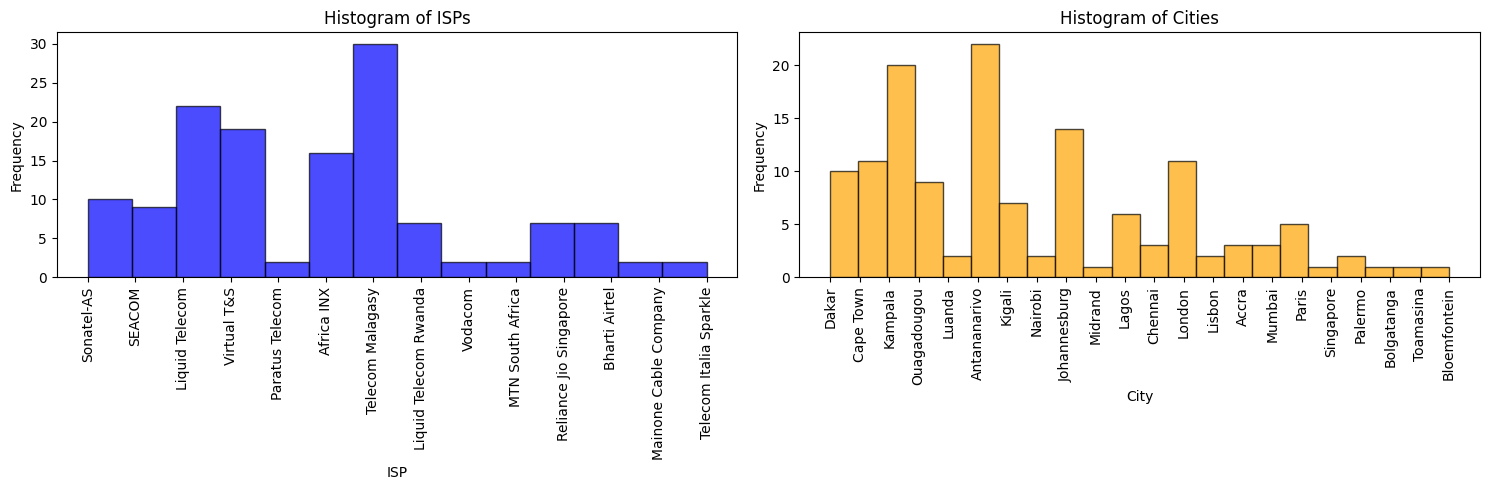

In [33]:
isp_list = []
country_list = []
city_list = []

ips_set = set()

replacements = {
    "AS16637 MTN SA":"MTN South Africa",
    "AS37100 SEACOM Limited": "SEACOM",
    "AS33763 Paratus Telecommunications Limited": "Paratus Telecom",
    "AS36994 Vodacom": "Vodacom",
    "AS9498 BHARTI Airtel Ltd.": "Bharti Airtel",
    "AS37006 Liquid Telecommunication Rwanda Limited": "Liquid Telecom Rwanda",
    "AS6762 TELECOM ITALIA SPARKLE S.p.A.": "Telecom Italia Sparkle",
    "AS37179 Africa Independent Network Exchange (Pty) LTD (AfricaINX)": "Africa INX",
    "AS37054 Telecom Malagasy": "Telecom Malagasy",
    "AS64049 Reliance Jio Infocomm Pte Ltd Singapore": "Reliance Jio Singapore",
    "AS37282 Mainone Cable Company": "Mainone Cable Company",
    "AS30844 Liquid Telecommunications Ltd": "Liquid Telecom",
    "AS8346 SONATEL-AS Autonomous System": "Sonatel-AS",
    "AS37721 Virtual Technologies & Solutions": "Virtual T&S"
}

for ip in load_balancing_routers:
    rtr = router_dict[ip]

    for key, value in replacements.items():
        if key in rtr.org:
            isp_list.append(value)
    city_list.append(rtr.city)



# Plot histograms for the three lists
plt.figure(figsize=(15, 5))

# Histogram for ISP list
plt.subplot(1, 2, 1)
plt.hist(isp_list, bins=len(set(isp_list)), color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of ISPs')
plt.xlabel('ISP')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

# Histogram for City list
plt.subplot(1, 2, 2)
plt.hist(city_list, bins=len(set(city_list)), color='orange', alpha=0.7, edgecolor='black')
plt.title('Histogram of Cities')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

plt.tight_layout()
print(f"Number of load balancing Hops: {load_balancing_instances}")
plt.show()

# (f) Identification of Common Transit Routers Outside India

Router locations that are common to most of the internet paths are:
1. Marseille (most common)
2. Los Angeles
3. Paris
4. Cape Town
5. Johannesburg